In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn import tree #Look at documentation: http://scikit-learn.org/stable/modules/tree.html
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # Helping you divide your datasets to train/test(validation)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from pandas import Series
from pandas.plotting import autocorrelation_plot

In [7]:
# Loading the data into the Pandas dataframe
df = pd.read_csv("bank_marketing.csv")


In [8]:
# Let's take a look at the data, first 10 rows:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


### Data Preparation and Pre-prediction Analysis

#### Treating Outliers

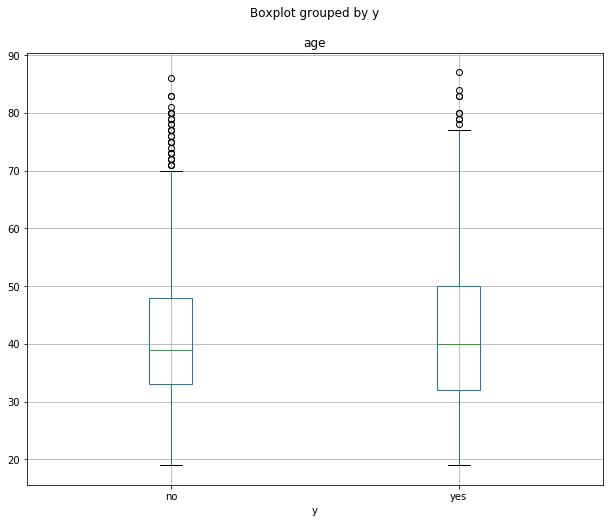

In [9]:
df.boxplot(column='age',by='y', figsize=(10,8));

In [10]:
df[(df.age>70) & (df.job != 'retired') & (df.job != 'unknown')]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
166,78,housemaid,married,secondary,no,499,no,no,telephone,16,mar,80,4,-1,0,unknown,no
688,80,management,married,primary,no,6483,no,no,telephone,19,oct,123,1,-1,0,unknown,no
1186,71,technician,married,tertiary,no,383,no,no,cellular,27,oct,327,2,183,3,success,no
1196,72,blue-collar,married,primary,no,4415,no,no,telephone,13,oct,120,1,-1,0,unknown,no
3157,75,blue-collar,married,secondary,no,6053,no,no,cellular,11,feb,865,2,190,1,failure,no
3690,80,housemaid,married,primary,no,0,no,no,cellular,23,feb,639,1,189,1,failure,yes


In [11]:
# Few of the outliers have age > 70 but still have jobs like blue-collar and housemaid, fill such records with mean age
df.loc[(df.age>70) & (df.job != 'retired') & (df.job != 'unknown'),'age'] = df.age.mean()


In [12]:
# There are still a few outliers in age but most of them are retired which makes sense hence we choose not to change them

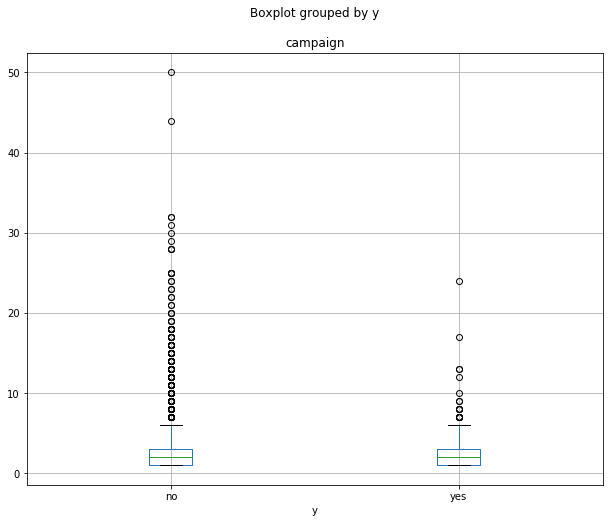

In [13]:
df.boxplot(column='campaign', by='y', figsize=(10,8));


In [14]:
# As per above boxplot, it doesnt make sense to call a customer more than 7 times. 
# Hence we fill the values > 7 with 75% value which is 3
df.loc[df['campaign'] > 7, 'campaign'] = 3

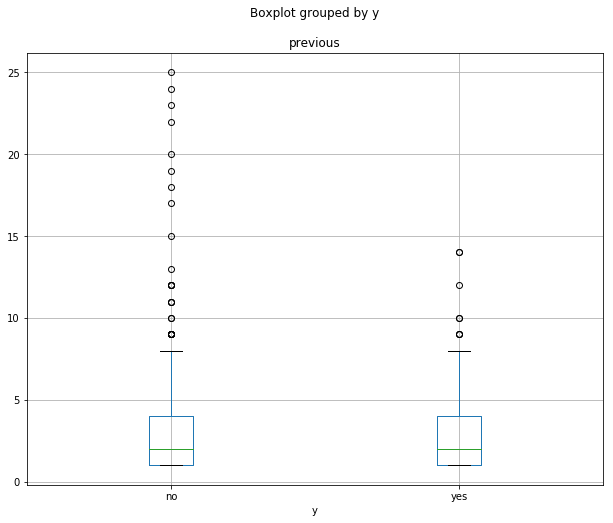

In [15]:
df[df.previous != 0].boxplot(column='previous', by='y', figsize=(10,8));

In [16]:
# As per above boxplot, it doesnt make sense to call a customer more than 7 times.
# Hence we fill the values > 7 with 75% value which is 4
df.loc[df['previous'] > 7, 'previous'] = 4

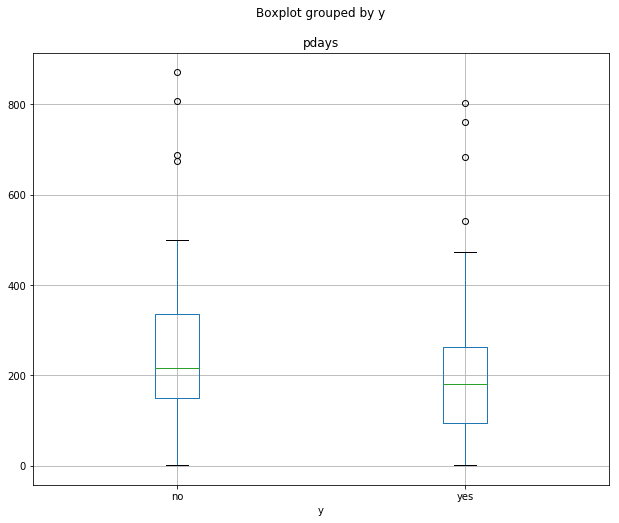

In [17]:
df[df.pdays != -1].boxplot(column='pdays', by='y', figsize=(10,8));

In [18]:
# Below are the records which has > 500 pdays. While we can take 75% value to correct them, 
# its not going to make much difference in the analysis below
df[df.pdays > 500]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1106,35.0,blue-collar,married,secondary,no,137,no,yes,unknown,4,oct,5,1,808,4,failure,no
1279,32.0,management,married,tertiary,no,913,yes,no,cellular,23,jun,883,1,674,4,failure,no
2249,49.0,unemployed,divorced,tertiary,no,780,no,no,cellular,8,nov,148,1,871,2,failure,no
2486,50.0,unknown,married,unknown,no,558,no,no,cellular,9,jul,464,1,683,6,failure,yes
3250,54.0,technician,married,tertiary,no,876,no,no,cellular,27,oct,269,3,541,3,success,yes
3301,60.0,services,married,tertiary,no,4256,yes,no,cellular,16,aug,239,3,761,1,other,yes
4073,51.0,management,married,tertiary,no,176,yes,yes,unknown,1,jun,8,1,687,2,failure,no
4423,45.0,management,single,tertiary,no,2048,yes,no,cellular,18,oct,310,1,804,1,failure,yes


#### Fill missing values (Data Cleaning)

In [19]:
# In order to fill the missing values, convert the columns to categorical first
df.job.astype('category')
df.education.astype('category')

0         primary
1       secondary
2        tertiary
3        tertiary
4       secondary
5        tertiary
6        tertiary
7       secondary
8        tertiary
9         primary
10      secondary
11      secondary
12       tertiary
13      secondary
14      secondary
15       tertiary
16      secondary
17       tertiary
18        primary
19      secondary
20        unknown
21       tertiary
22      secondary
23      secondary
24       tertiary
25       tertiary
26        primary
27        unknown
28      secondary
29      secondary
          ...    
4491    secondary
4492    secondary
4493     tertiary
4494    secondary
4495     tertiary
4496    secondary
4497     tertiary
4498     tertiary
4499      primary
4500    secondary
4501     tertiary
4502    secondary
4503      primary
4504    secondary
4505    secondary
4506     tertiary
4507    secondary
4508      unknown
4509     tertiary
4510    secondary
4511    secondary
4512    secondary
4513    secondary
4514    secondary
4515    se

In [20]:
# This function checks for the similar profile and fill the unknown job with most frequent value 
def get_job_based_on_similarity(row):
    values=df[(df.age == row.age) & (df.marital == row.marital) & (df.default == row.default) 
       & (df.housing == row.housing) & (df.loan == row.loan)]
    most=values.job.describe().top
    if most == 'unknown':
        most =values[values.job != 'unknown'].job.describe().top
    return most

In [21]:
# Show missing values before, i.e. has 'unknown'
df.job.unique()

array(['unemployed', 'services', 'management', 'blue-collar',
       'self-employed', 'technician', 'entrepreneur', 'admin.', 'student',
       'housemaid', 'retired', 'unknown'], dtype=object)

In [22]:
# Perform the fill operation
df.loc[df.job == 'unknown','job'] = df[df.job == 'unknown'].apply(get_job_based_on_similarity,axis=1)


In [23]:
 # Job values for entire dataset after, 'unknown' is gone
df.job.unique()

array(['unemployed', 'services', 'management', 'blue-collar',
       'self-employed', 'technician', 'entrepreneur', 'admin.', 'student',
       'housemaid', 'retired'], dtype=object)

In [24]:
# It was observed the while to apply the same logic of similar profiles for education doesnt work for all the records.
# There are 6 records which dont have any exact match.
# So need to fill that missing values by dropping matching criteria step by step.
# For ex. start with age, marital, default, housing, loan. If not match found, drop loan from match criteria. 
# If still couldnt find any match, drop housing, and so on.

In [25]:
# Generate string expression based on matching criteria
# output would be (age==41) & (marital=='married') ...
def combination_generator(row,*args):
    expression=""
    for arg in args:
        if(arg=='age'):
            expression = expression + "(%s==%s) & " % (arg, row[arg])
        else:
            expression = expression + "(%s=='%s') & " % (arg, row[arg])
    return expression[:-2]

In [26]:
def get_education_based_on_similarity(row, *args):
    # start with n=5 parameters (age, marital, default, housing, loan)
    t = combination_generator(row,*args)
    values1=df[df.eval(t)]
    most1=values1.education.describe().top
    if most1 == 'unknown':
        if(values1[values1.education != 'unknown'].empty):
            # This means there are no records with 'n' matching parameters, start reducing by n-1 until match found
            most1 = get_education_based_on_similarity(row,*args[:-1])
        else:
            # Match found, take the most frequent education which is not 'unknown'
            most1 =values1[values1.education != 'unknown'].education.describe().top
    return most1
    

In [27]:
#Show data before
df.education.unique()

array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object)

In [28]:
# Perform fill operation
df.loc[df.education == 'unknown','education'] = df[df.education == 'unknown'].apply(get_education_based_on_similarity,axis=1, args=('age','marital','default','housing','loan'))

In [29]:
# After 
df.education.unique()

array(['primary', 'secondary', 'tertiary'], dtype=object)

#### Feature Engineering

In [30]:
# Convert duration in seconds to categorical bin of minutes range
bins = [0,5,10,60]
bin_labels = ['0-4', '5-9','>10']
df['duration_mintues'] = pd.cut(df.duration/60, bins, right=False, labels = bin_labels)
df.duration_mintues.astype('category')

0       0-4
1       0-4
2       0-4
3       0-4
4       0-4
5       0-4
6       5-9
7       0-4
8       0-4
9       5-9
10      0-4
11      0-4
12      5-9
13      0-4
14      0-4
15      0-4
16      0-4
17      0-4
18      0-4
19      0-4
20      0-4
21      0-4
22      0-4
23      0-4
24      0-4
25      0-4
26      0-4
27      0-4
28      0-4
29      0-4
       ... 
4491    0-4
4492    5-9
4493    0-4
4494    5-9
4495    >10
4496    0-4
4497    0-4
4498    >10
4499    5-9
4500    0-4
4501    0-4
4502    0-4
4503    >10
4504    >10
4505    >10
4506    0-4
4507    5-9
4508    5-9
4509    0-4
4510    0-4
4511    >10
4512    >10
4513    5-9
4514    0-4
4515    >10
4516    5-9
4517    0-4
4518    0-4
4519    0-4
4520    5-9
Name: duration_mintues, Length: 4521, dtype: category
Categories (3, object): [0-4 < 5-9 < >10]

#### Pre-prediction Analysis

In [31]:
df_copy = df.copy()

In [32]:
df_copy.y.replace(['no', 'yes'], [0, 1], inplace=True)

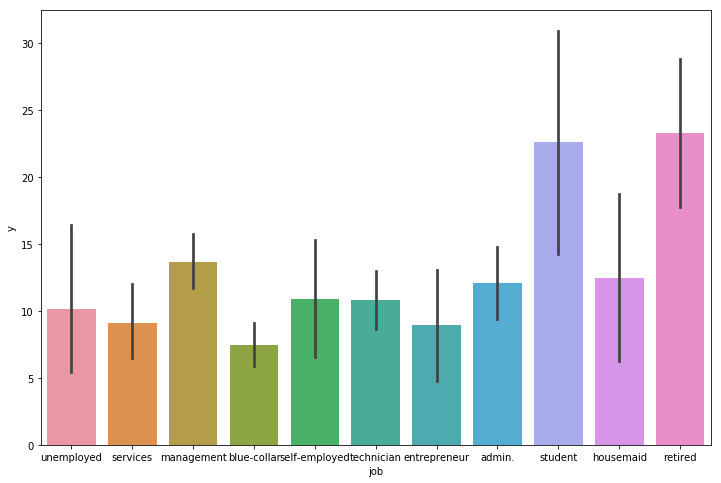

In [33]:
# Retired and Students are most likely to purchase products
plt.rcParams['figure.figsize']=(12,8)
sns.barplot(x='job', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

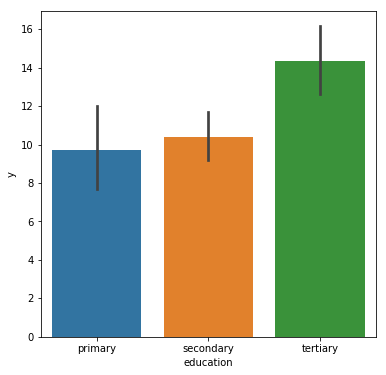

In [34]:
# Tertiary Education are more likely to purchase the product
plt.rcParams['figure.figsize']=(6,6)
sns.barplot(x='education', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

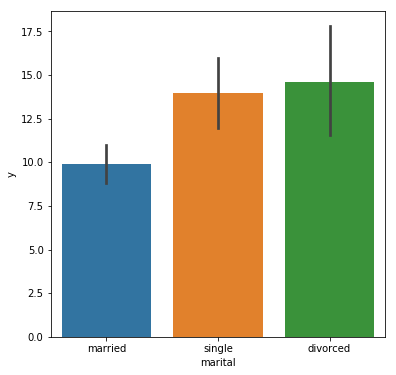

In [35]:
# Single & Divorced are more likely to purchase products
plt.rcParams['figure.figsize']=(6,6)
sns.barplot(x='marital', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

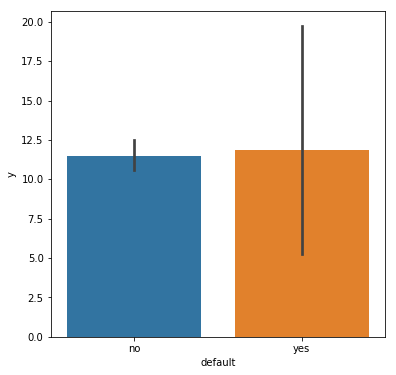

In [36]:
# No real difference between default yes or no
plt.rcParams['figure.figsize']=(6,6)
sns.barplot(x='default', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

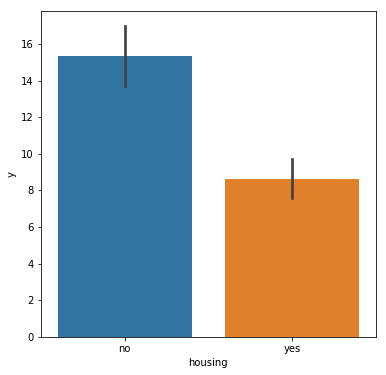

In [37]:
# Housing and Loan exhibit the same likelihood of y or n, so we choose to keep just housing column in prediction
plt.rcParams['figure.figsize']=(6,6)
sns.barplot(x='housing', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

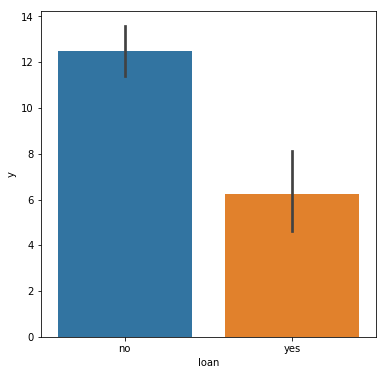

In [38]:
# Housing and Loan exhibit the same likelihood of y or n, so we choose to keep just housing column in prediction
plt.rcParams['figure.figsize']=(6,6)
sns.barplot(x='loan', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

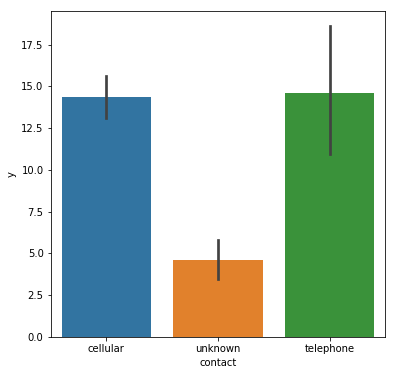

In [39]:
# Contacting method doesn't make a difference, since it doesnt matter how you talk to the customer, 
# as long as we have the conversation and explain about the products, 
# it serves the purpose and hence we choose to drop this column from analysis
plt.rcParams['figure.figsize']=(6,6)
sns.barplot(x='contact', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

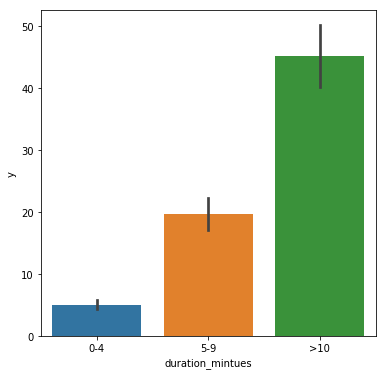

In [40]:
# The longer the duration of the call, the higher the chance of a purchase
plt.rcParams['figure.figsize']=(6,6)
sns.barplot(x='duration_mintues', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

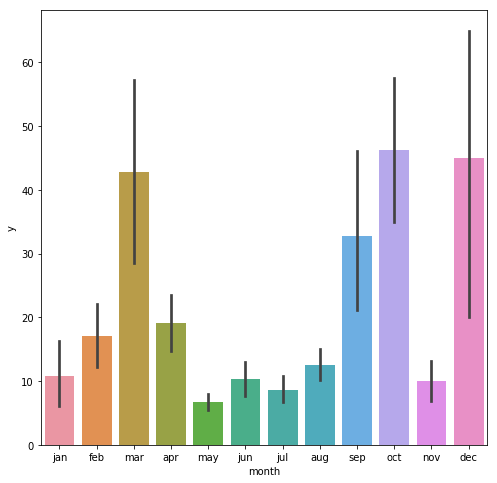

In [41]:
# There seems to be few higher probability months where customers agrees to buy.
plt.rcParams['figure.figsize']=(8,8)
df_month_sorted = df_copy.copy()
df_month_sorted.month = pd.Categorical(df_month_sorted.month, 
                      categories=['jan', 'feb','mar', 'apr','may', 'jun','jul', 'aug','sep', 'oct','nov', 'dec'],
                      ordered=True)

sns.barplot(x='month', y='y', data=df_month_sorted, estimator=lambda x: sum(x==1)*100.0/len(x))

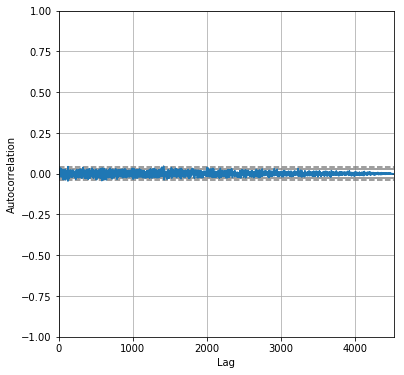

In [42]:
# As expected, we cannot decipher any sesonality trend due to lack of data from the below ACF plot. 
# But as per above bar plot, contacting customers in the month of March, October and December has higher chances of them agreeing to buy products.

plt.rcParams['figure.figsize']=(6,6)
df_copy['month_number'] = df_copy.month.replace(['jan', 'feb','mar', 'apr','may', 'jun','jul', 'aug','sep', 'oct','nov', 'dec'], [ 1,2,3,4,5,6,7,8,9,10,11,12])
df_copy['date'] =pd.to_datetime((2018*10000+df_copy.month_number*100+df_copy.day).apply(str),format='%Y%m%d')
df_time = df_copy[['date', 'y']].copy()
ts = pd.Series(df_time['y'].values, index=df_time['date'])
autocorrelation_plot(ts)

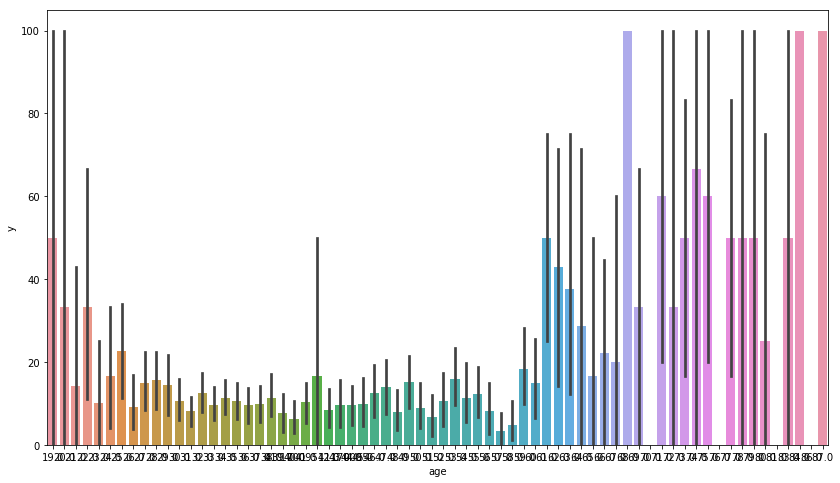

In [43]:
# Most customers are in the range of 25-60 years old range. Out of that, the likelihood of someone accepting the product vs rejecting are equally likely
# People in younger and older age range outside of that seem to have higher chance of saying yes
plt.rcParams['figure.figsize']=(14,8)
sns.barplot(x='age', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000176F7DB88D0>]],
      dtype=object)

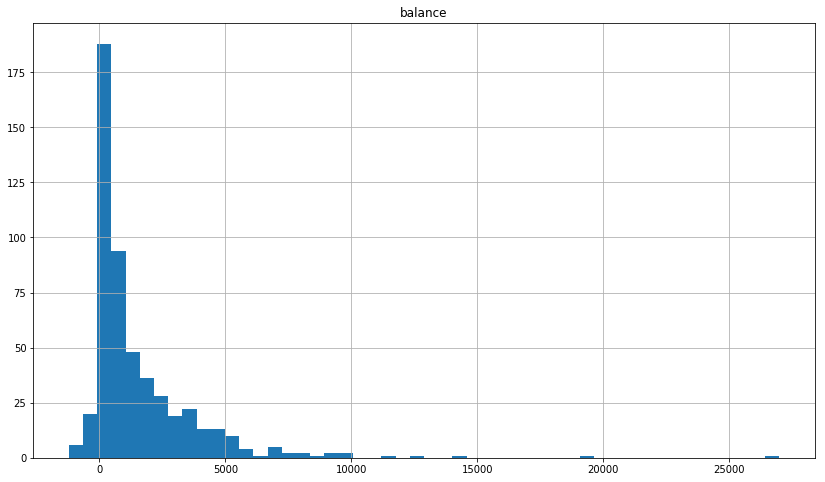

In [44]:
# The distribution of the balance in the data is very right skewed. However, The -500 to 5000 range seem to most likely say yes.
# Ideally, only people having high balance would have spare money to invest in long term products. So why are we seeing a reverse trend?
# It seems like single and divorced people tend to buy the product compared to the married, which shows they have likely less source of income. 
# Also occupation wise, low income groups (students and retired) tend to buy the product. 
# This probably shows that the product that the bank is trying to promote is targeted for people who are not wealthy.
# But if a person already has low balance, locking it into a long term investment product, will make it difficult to cover monthly cost of living. 
# Perhaps if we know the minimum amount for such long term investments, it will be easy to answer.
#  For now we choose to drop this column since we dont have enough information to justify the trend we see in the data.
df_copy[df_copy.y==1].hist(column='balance', bins=50)

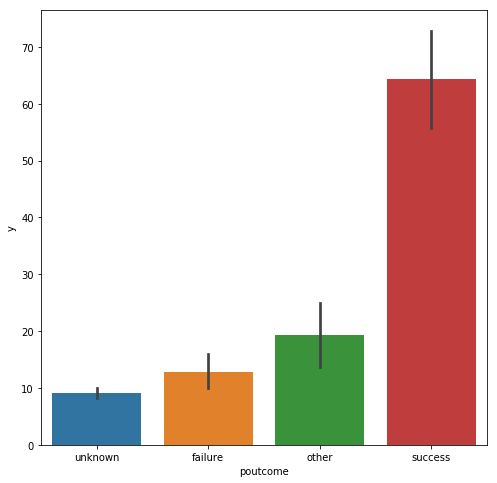

In [45]:
# It seems that repeat business is quite prevelant. 
# Most of the customers who bought the products in the previous campaign also agreed in the current campaign
plt.rcParams['figure.figsize']=(8,8)
sns.barplot(x='poutcome', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

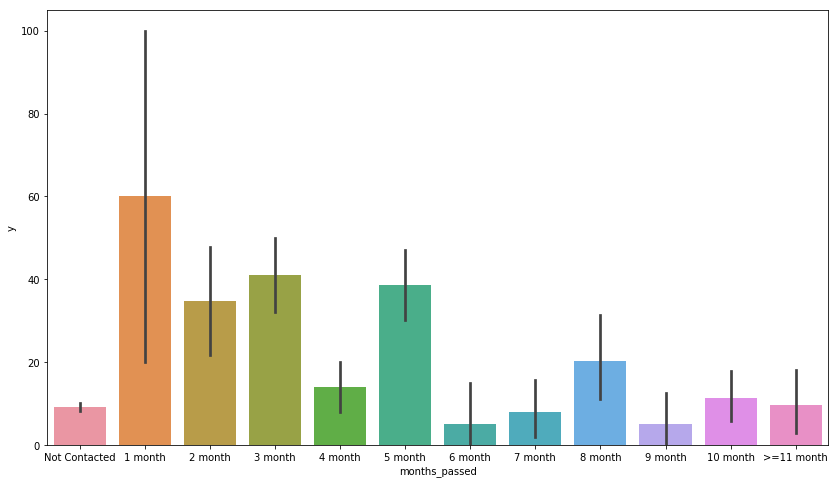

In [46]:
# Plot below shows that the chances are very high when customer where contacted within first month after the previous campaign ended.
# Also new customers (who were never contacted in the previous campaign), have very less chance of buying the product irrespective of number of contacts made in current campaign
days_passed_bins = [-1,30,60,90,120,180,210,240,270,300,330,360,390]
days_passed_bin_labels = ['Not Contacted','1 month', '2 month','3 month','4 month','5 month','6 month','7 month','8 month','9 month','10 month','>=11 month']
df_copy['months_passed'] = pd.cut(df_copy.pdays, days_passed_bins, right=False, labels = days_passed_bin_labels)
df_copy.months_passed.astype('category')
plt.rcParams['figure.figsize']=(14,8)
sns.barplot(x='months_passed', y='y', data=df_copy, estimator=lambda x: sum(x==1)*100.0/len(x))

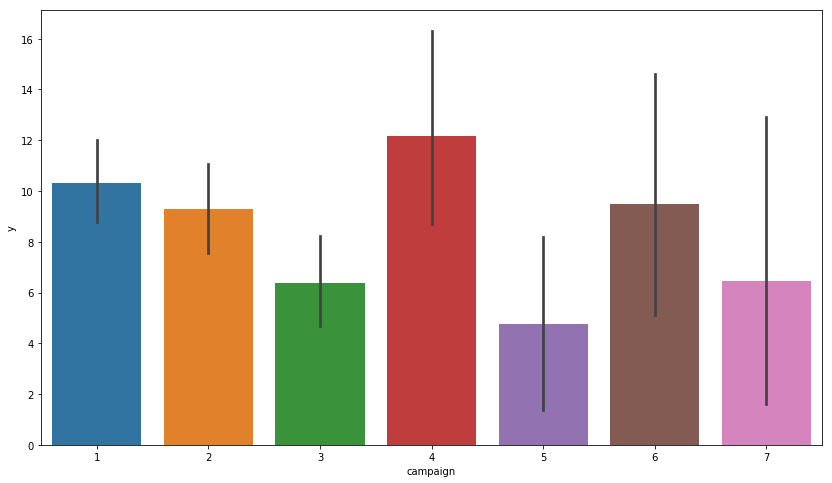

In [47]:
# Number of contacts in the current campaign for new customers, have nearly the same chance of buying
sns.barplot(x='campaign', y='y', data=df_copy[df_copy.pdays==-1], estimator=lambda x: sum(x==1)*100.0/len(x))

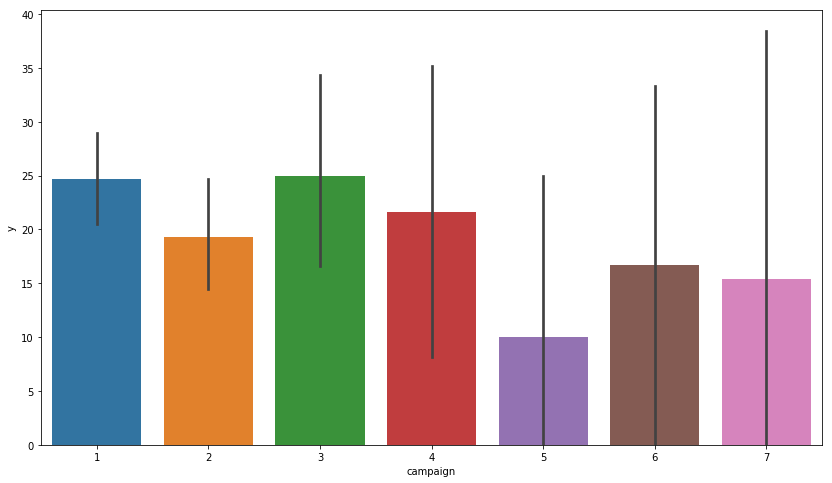

In [48]:
# 4 is the Number of contacts in the current campaign for old customers, after which chances decline
sns.barplot(x='campaign', y='y', data=df_copy[df_copy.pdays!=-1], estimator=lambda x: sum(x==1)*100.0/len(x))

In [49]:
df.drop(['balance','contact','day','duration','default', 'loan'],inplace=True,axis=1)
df.head()

,age,job,marital,education,housing,month,campaign,pdays,previous,poutcome,y,duration_mintues
0,30.0,unemployed,married,primary,no,oct,1,-1,0,unknown,no,0-4
1,33.0,services,married,secondary,yes,may,1,339,4,failure,no,0-4
2,35.0,management,single,tertiary,yes,apr,1,330,1,failure,no,0-4
3,30.0,management,married,tertiary,yes,jun,4,-1,0,unknown,no,0-4
4,59.0,blue-collar,married,secondary,yes,may,1,-1,0,unknown,no,0-4


### Predictive Modeling (Classification)

In [50]:
# http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features
# http://pbpython.com/categorical-encoding.html
cols_to_transform = [ 'job', 'marital','education','housing', 'month','y','duration_mintues','poutcome' ]
df_with_dummies = pd.get_dummies(df, columns = cols_to_transform )


In [51]:
df_with_dummies.reindex(['age', 'job', 'marital', 
                                    'education','housing',
                                    'month', 'duration_mintues','campaign','pdays','previous','poutcome', 'y'],axis=1)


,age,job,marital,education,housing,month,duration_mintues,campaign,pdays,previous,poutcome,y
0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,1,-1,0,NaN,NaN
1,33.0,NaN,NaN,NaN,NaN,NaN,NaN,1,339,4,NaN,NaN
2,35.0,NaN,NaN,NaN,NaN,NaN,NaN,1,330,1,NaN,NaN
3,30.0,NaN,NaN,NaN,NaN,NaN,NaN,4,-1,0,NaN,NaN
4,59.0,NaN,NaN,NaN,NaN,NaN,NaN,1,-1,0,NaN,NaN
5,35.0,NaN,NaN,NaN,NaN,NaN,NaN,2,176,3,NaN,NaN
6,36.0,NaN,NaN,NaN,NaN,NaN,NaN,1,330,2,NaN,NaN
7,39.0,NaN,NaN,NaN,NaN,NaN,NaN,2,-1,0,NaN,NaN
8,41.0,NaN,NaN,NaN,NaN,NaN,NaN,2,-1,0,NaN,NaN
9,43.0,NaN,NaN,NaN,NaN,NaN,NaN,1,147,2,NaN,NaN


In [52]:

# Split-out validation dataset
array = df_with_dummies.values
X = array[:,0:11] # Features/Independent Variables

Y = array[:,11] # Response/Class Variable

# One-third of data as a part of test set
validation_size = 0.33

seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

train_size = len(X_train)
val_size = len(X_validation)


clf = GaussianNB()
#Fitting the training set
clf.fit(X_train, Y_train) 
#Predicting for the Test(Validation) Set
pred_clf = clf.predict(X_validation)
accuracy_score(Y_validation, pred_clf, normalize = True)

0.7808310991957105

In [53]:
# Initialize Decision Tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train, Y_train)
pred_clf_tree= clf_tree.predict(X_validation)
accuracy_score(Y_validation, pred_clf_tree, normalize = True)

0.8987935656836461

In [54]:
# Initialize RFC
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train,Y_train)
pred_rcf= rfc.predict(X_validation)
accuracy_score(Y_validation, pred_rcf, normalize = True)

0.896112600536193

In [55]:
# Test options and evaluation metric
scoring = 'accuracy'

#Model Performance
#setting performance parameters
kfold = model_selection.KFold(n_splits=10, random_state=seed)

#calling the cross validation function
cv_results = model_selection.cross_val_score(GaussianNB(), X_train, Y_train, cv=kfold, scoring=scoring)

#displaying the mean and standard deviation of the prediction
msg = "%s: %f (%f)" % ('NB accuracy', cv_results.mean(), cv_results.std())
print(msg)

#calling the cross validation function
cv_results_tree = model_selection.cross_val_score(tree.DecisionTreeClassifier(), X_train, Y_train, cv=kfold, scoring=scoring)

#displaying the mean and standard deviation of the prediction
msg = "%s: %f (%f)" % ('Decision Tree accuracy', cv_results_tree.mean(), cv_results_tree.std())
print(msg)

#calling the cross validation function
cv_results_rfc = model_selection.cross_val_score(RandomForestClassifier(), X_train, Y_train, cv=kfold, scoring=scoring)

#displaying the mean and standard deviation of the prediction
msg = "%s: %f (%f)" % ('RFC accuracy', cv_results_rfc.mean(), cv_results_rfc.std())
print(msg)

NB accuracy: 0.781766 (0.025380)
Decision Tree accuracy: 0.889397 (0.014598)
RFC accuracy: 0.893691 (0.015489)


In [56]:
# Above high accuracy in predictions can be attributed to overfitting. 
# Reducing the number of features as below shows that for Naive Bayes, the accuracy reduces significantly while Decision Tree and RF still perform better 

In [57]:
# http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features
df.drop(['education','housing','month'],inplace=True,axis=1)
df3 = df.copy()
cols_to_transform = [ 'job', 'marital','y','duration_mintues','poutcome' ]
df_with_dummies = pd.get_dummies(df3, columns = cols_to_transform )

df_with_dummies.reindex(['age', 'job', 'marital', 
                                     'duration_mintues','campaign','pdays','previous','poutcome', 'y'],axis=1)

									# Split-out validation dataset
array = df_with_dummies.values
X = array[:,0:8] # Features/Independent Variables

Y = array[:,8] # Response/Class Variable

# One-third of data as a part of test set
validation_size = 0.33

seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

train_size = len(X_train)
val_size = len(X_validation)


clf = GaussianNB()
#Fitting the training set
clf.fit(X_train, Y_train) 
#Predicting for the Test(Validation) Set
pred_clf = clf.predict(X_validation)
accuracy_score(Y_validation, pred_clf, normalize = True)

# Initialize Decision Tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train, Y_train)
pred_clf_tree= clf_tree.predict(X_validation)
accuracy_score(Y_validation, pred_clf_tree, normalize = True)

# Initialize RFC
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train,Y_train)
pred_rcf= rfc.predict(X_validation)
accuracy_score(Y_validation, pred_rcf, normalize = True)

# Test options and evaluation metric
scoring = 'accuracy'

#Model Performance
#setting performance parameters
kfold = model_selection.KFold(n_splits=10, random_state=seed)

#calling the cross validation function
cv_results = model_selection.cross_val_score(GaussianNB(), X_train, Y_train, cv=kfold, scoring=scoring)

#displaying the mean and standard deviation of the prediction
msg = "%s: %f (%f)" % ('NB accuracy', cv_results.mean(), cv_results.std())
print(msg)

#calling the cross validation function
cv_results_tree = model_selection.cross_val_score(tree.DecisionTreeClassifier(), X_train, Y_train, cv=kfold, scoring=scoring)

#displaying the mean and standard deviation of the prediction
msg = "%s: %f (%f)" % ('Decision Tree accuracy', cv_results_tree.mean(), cv_results_tree.std())
print(msg)

#calling the cross validation function
cv_results_rfc = model_selection.cross_val_score(RandomForestClassifier(), X_train, Y_train, cv=kfold, scoring=scoring)

#displaying the mean and standard deviation of the prediction
msg = "%s: %f (%f)" % ('RFC accuracy', cv_results_rfc.mean(), cv_results_rfc.std())
print(msg)

NB accuracy: 0.593254 (0.021702)
Decision Tree accuracy: 0.755034 (0.021943)
RFC accuracy: 0.747432 (0.034730)


### Conclusions and Recommendations

In [58]:
# Conclusions

# Retired and Students are most likely to purchase products

# Tertiary Education are more likely to purchase the product

# Single & Divorced are more likely to purchase products

# No real difference between default yes or no

# Housing and Loan exhibit the same likelihood of y or n, so we choose to keep just housing column in prediction

# Contacting method doesn't make a difference, since it doesnt matter how you talk to the customer, 
# as long as we have the conversation and explain about the products, 
# it serves the purpose and hence we choose to drop this column from analysis

# The longer the duration of the call, the higher the chance of a purchase

# Contacting customers in the month of March, October and December has higher chances of them agreeing to buy products.

# Most customers are in the range of 25-60 years old range. Out of that, the likelihood of someone accepting the product vs rejecting are equally likely
# People in younger and older age range outside of that seem to have higher chance of saying yes

# The distribution of the balance in the data is very right skewed. However, The -500 to 5000 range seem to most likely say yes.
# Ideally, only people having high balance would have spare money to invest in long term products. So why are we seeing a reverse trend?
# It seems like single and divorced people tend to buy the product compared to the married, which shows they have likely less source of income. 
# Also occupation wise, low income groups (students and retired) tend to buy the product. 
# This probably shows that the product that the bank is trying to promote is targeted for people who are not wealthy.
# But if a person already has low balance, locking it into a long term investment product, will make it difficult to cover monthly cost of living. 
# Perhaps if we know the minimum amount for such long term investments, it will be easy to answer.
#  For now we choose to drop this column since we dont have enough information to justify the trend we see in the data.


# The chances are very high when customer where contacted within first month after the previous campaign ended.
# Also new customers (who were never contacted in the previous campaign), have very less chance of buying the product irrespective of number of contacts made in current campaign

# Number of contacts in the current campaign for new customers, have nearly the same chance of buying

# 4 is the Number of contacts in the current campaign for old customers, after which chances decline
# It seems that repeat business is quite prevelant. Most of the customers who bought the products in the previous campaign also agreed in the current campaign

In [59]:
# Recommendations
# 1. Focus on repeat business
# 2. Call duration should be around 5-10 minutes
# 3. Try and contact customers within first month of previous campaign
# 4. Target students and retired people first
